In [1]:
###########################################################################
# Random Erasing,RandomErasing - ResNet(CIFAR-10、CIFAR10)
###########################################################################
# 参考
# https://qiita.com/gragragrao/items/112dad421d5c34855755

#==============================================================
# 1.インポート/宣言
#==============================================================

from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.datasets import cifar10
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc import toimage
from PIL.Image import fromarray as toimage


BATCH_SIZE = 50
#EPOCHS = 10
EPOCHS = 5



Using TensorFlow backend.


In [2]:
#==============================================================
# 2.画像のダウンロード
#==============================================================
# CIFAR-10 の画像をロードする
# 普通はネットからダウンロードしてきてそれを読み込むのだが、
# KerasではCIFAR10をダウンロードしてきて読み込むところまでを
# やってくれる機能があるのでそれを使っている
(X_train_load, y_train_load), (X_test_load, y_test_load) = cifar10.load_data()

##X_train_load= [[[[ 59  62  63]
##   [ 43  46  45]
##   [ 50  48  43]
##   ...
##   [158 132 108]
##   [152 125 102]
##   [148 124 103]]
##
##  [[ 16  20  20]
##   [  0   0   0]
##   [ 18   8   0]
##   ...
##   [123  88  55]
##   [119  83  50]
##   [122  87  57]]
##   ・・・
##
##y_train_load= [[6]
## [9]
## [9]
## ...
## [9]
## [1]
## [1]]
##
##X_test_load= [[[[158 112  49]
##   [159 111  47]
##   [165 116  51]
##   ...
##   [137  95  36]
##   [126  91  36]
##   [116  85  33]]
##
##y_test_load= [[3]
## [8]
## [8]
## ...
## [5]
## [1]
## [7]]

# CIFAR-10の教師データは 0 ～ 9 までの数字になっているが、これだと人はわかりにくいので
# 0 → airplane, 1 → automobile…のような対応関係を配列で持っておく
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

170500096/170498071 [==============================] - 9s 0us/step


In [0]:
# ////////////////////////////////////////////////////
# 3.読み込んだデータのままで実施
# ////////////////////////////////////////////////////

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


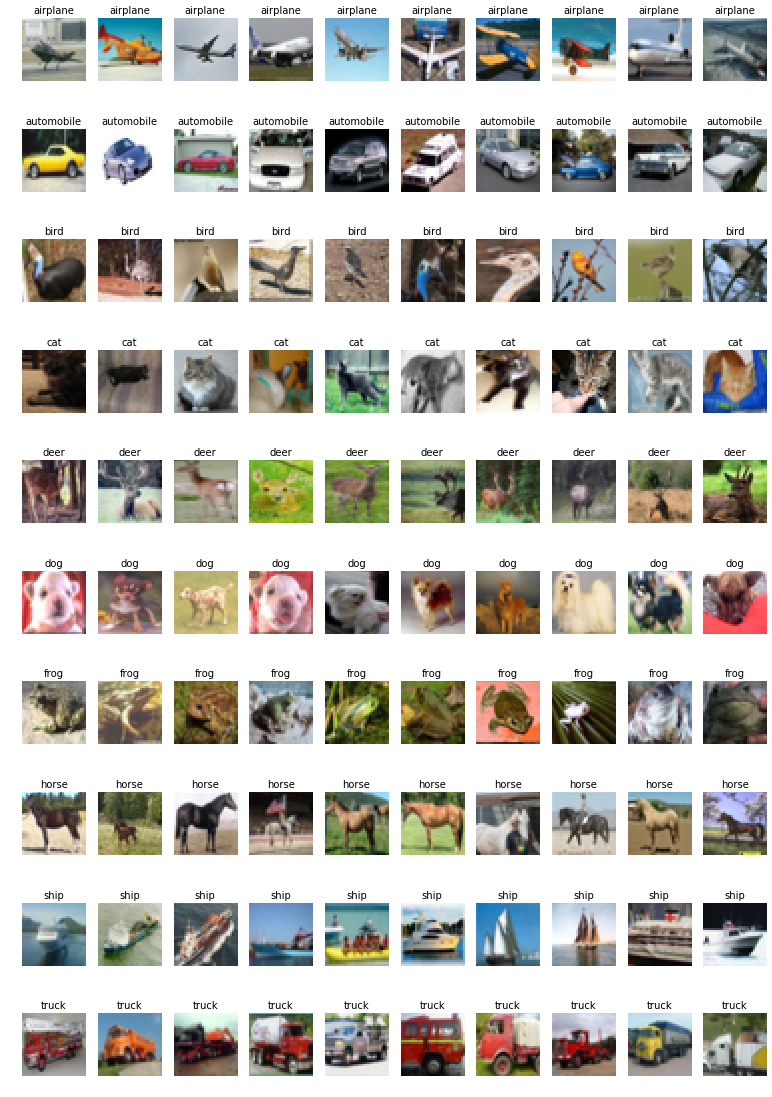

In [4]:
#==============================================
# 3-1.事前のデータ確認
#==============================================

import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc import toimage


X_train = X_train_load.copy()
y_train = y_train_load.copy()
X_test = X_test_load.copy()
y_test = y_test_load.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#==================
# クラスごとの描画関数
#==================
def classShowFunc(X_train_input, y_train_input):
    nclasses = 10
    pos = 1
    # w16,h24のエリアに描画する。
    plt.figure(figsize=(16,24), dpi=60)
    
    # matplotlib で学習用画像を10個ずつ表示する
    # matplotlib はグラフを表示するためのライブラリでものすごく多機能なため、
    # 便利ではあるがかなりとっつきづらい
    # 細かい説明はキリがないので興味があれば調べてみてほしい。
    # クラス毎にループを回す(0～9)
    for targetClass in range(nclasses):
        targetIdx = []
        for i in range(len(y_train_input)):
            if y_train_input[i][0] == targetClass:
                # 対応するクラスのy_train_inputのインデックスを保持する
                targetIdx.append(i)
    
        # 配列をランダムに並べ変える
        np.random.shuffle(targetIdx)
        # クラス内の先頭10個だけ選んで表示
        for idx in targetIdx[:10]:
            # X_train_input[idx] は3次元の行列になっており、そのままだと数字の羅列が表示されるだけなので
            # toimage を使って画像に変換してから表示する
            img = toimage(X_train_input[idx])
            
            # 縦10×横10ファイル数を表示
            plt.subplot(10, 10, pos)
            plt.imshow(img)
            plt.axis('off')
            # タイトルにラベルを表示
            plt.title(cifar10_labels[y_train_input[idx][0]])
            pos += 1
    
    plt.show()


########
classShowFunc(X_train, y_train)





In [0]:
#==============================================
# 3-2.データ変換
#==============================================

# floatに変換しておく
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 正規化
X_train /= 255.0
X_test /= 255.0

# one-hot vector に変換したほうが都合が良い
# たとえば 4 ではなくて [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] のようなデータにする
# ##ラベルに距離の属性を持たせなくて済む！！！
# こうしないとクラス分類ではなくて回帰として扱われてしまいうまくいかない
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

##【one-hot vectorとは】
##ダミー変数に変換すること！！！
##val      val_a   val_b   val_c
##----  → ------  ------  ------
##a          1       0       0
##b          0       1       0
##c          0       0       1

##X_train =  [[[[0.23137255 0.24313726 0.24705882]
##   [0.16862746 0.18039216 0.1764706 ]
##   [0.19607843 0.1882353  0.16862746]
##   ...
##   [0.7019608  0.69411767 0.6784314 ]
##   [0.6431373  0.6431373  0.63529414]
##   [0.6392157  0.6392157  0.6313726 ]]]]
##  
##X_test =  [[[[0.61960787 0.4392157  0.19215687]
##   [0.62352943 0.43529412 0.18431373]
##   [0.64705884 0.45490196 0.2       ]
##   ...
##   [0.4509804  0.45490196 0.36862746]
##   [0.25882354 0.25490198 0.23137255]
##   [0.10588235 0.10588235 0.10588235]]
##  
##       INDEX:0～0
##Y_train =  [[0. 0. 0. ... 0. 0. 0.]
## [0. 0. 0. ... 0. 0. 1.]
## [0. 0. 0. ... 0. 0. 1.]
## ...
## [0. 0. 0. ... 0. 0. 1.]
## [0. 1. 0. ... 0. 0. 0.]
## [0. 1. 0. ... 0. 0. 0.]]
##  
##      INDEX:0～0
##Y_test =  [[0. 0. 0. ... 0. 0. 0.]
## [0. 0. 0. ... 0. 1. 0.]
## [0. 0. 0. ... 0. 1. 0.]
## ...
## [0. 0. 0. ... 0. 0. 0.]
## [0. 1. 0. ... 0. 0. 0.]
## [0. 0. 0. ... 1. 0. 0.]]



In [6]:
#==============================================
# 3-3.ResNet のモデル構築
#==============================================


#==================
#　サブ関数 
#==================
# inputs と residual 2つの処理結果を受け取って、両者を足す
def _shortcut(inputs, residual):
  
  # residual のほうのフィルタ数を取得する
  # ちなみに
  # _keras_shape[0] ★Noneが入っている.★
  # _keras_shape[1] 画像の高さ
  # _keras_shape[2] 画像の幅
  # _keras_shape[3] チャンネル数(filter数)
  # になっている(デフォルトでは)。
  # 本当はチャンネル数、幅、高さの順番のこともあるので
  # それを考慮したコードにしなければならないのだが、今回はこれで問題ない
  n_filters = residual._keras_shape[3]
  
  ## 例)residual._keras_shape ： (None, 16, 16, 64)
  
  # inputs と residual とでチャネル数が違うかもしれない。
  # そのままだと足せないので、1x1 conv を使って residual 側のフィルタ数に合わせている
  # ★フィルタ数を合わせるためだけにConvolution2Dする。n_filtersにする！！
  #   高さと幅は変わらない。カーネルサイズ1(h)×1(w),ストライド1(h)×1(w)
  #   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  shortcut = Convolution2D(n_filters, (1,1), strides=(1,1), padding='valid')(inputs)
  
  
  # 2つを足す
  # ★計算して出てきた特徴map:h×w×C　と　スキップで渡されてきた入力特徴map:h×w×C の対応する要素を足し合わせている。
  # h,w,Cをそれぞれ一致させること！！！上の2行で実現している。
  # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  # kerasのadd。「+」ではだめ！！！
  return add([shortcut, residual])


#==================
#　サブ関数(ハイパーパラメータ)(入力データ) ← KERASのAPI風の表記
#==================
# ResBlock を定義
# ここでの処理は BatchNorm → ReLU → Conv とシンプルなものにしてあるが、
# ここを色々変更する改良案が無数にある
#             ハイパーパラメータ
def _resblock(n_filters, strides=(1,1)):
  # 入力データ
  # input ← x
  def f(input):
    # n_filters:C(チャネル)
    # w,hが変わらない。padding='same'
    # x ← input
    # 第2引数 filter:3(h)×3(w)
    x = Convolution2D(n_filters, (3,3), strides=strides,
                                      kernel_initializer='he_normal', padding='same')(input)
    x = BatchNormalization()(x)  # ← 正規化
    x = Activation('relu')(x)
    x = Convolution2D(n_filters, (3,3), strides=strides,
                                      kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    
    # 入力そのもの(スキップ)と、BN→ReLU→Conv したものとを足す
    # ★この部分がResNetのもっとも重要な点(スキップのinput + x)
    return _shortcut(input, x)

  # 関数を返す
  return f

#==================
#　全体
#==================
def resnet():
  # 入力テンソルを定義しておく
  # 画像のサイズ(h,w,チャネル数(RGBで3))
  inputs = Input(shape=(32, 32, 3))
  
  # ResBlock で処理をする前に、いったん
  # 7(h)×7(w)で畳み込み→BN→ReLU　をし、さらに MaxPooling している
  # これは無くても動くが、早い段階でとりあえずMaxPoolingすることで画像サイズが1/2になるので
  # パラメータ数の増加を抑える(高速に学習できる)効果がある
  
  # +++++++++++++++++++++++++++++++++++++++++++++++++
  # ★【kerasの思想】
  # ハイパーパラメータと入力を分けたい！！！
  # レイヤのインスタンスを作る。データを入力する。
  # functional API
  # x を入力と返り値で持つ。ひたすらxを更新し続ける。
  # +++++++++++++++++++++++++++++++++++++++++++++++++
  
  # 第1引数 filter数  32:
  # 第2引数 filter:7(h)×7(w)
  # strides=(1(h),1(w))
  # conv→BN→ReLU
  x = Convolution2D(32, (7,7), strides=(1,1),
                    kernel_initializer='he_normal', padding='same')(inputs)
  # BatchNormalization：学習がスムーズに行えるように強制的にアクティベーション(活性化関数の後の出力データ)の分布を調整すること。正則化の手法。
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  # MaxPoolingで縮小
  # 第1引数は、pool_size=(3(h), 3(w))
  # 第2引数は、strides=(2(h),2(w))
  x = MaxPooling2D((3, 3), strides=(2,2), padding='same')(x)
  
  #ここからは ResBlock を積み重ねていく
  # 下では ResBlock x3 → MaxPooling → ResBlock x3 という非常に小さいネットワーク
  
  # _resblockはサブ関数(ハイパーパラメータ)(入力)の構造。
  # フィルタ数を2倍にする
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  #  pool_size=(2, 2)←デフォルト
  x = MaxPooling2D(strides=(2,2))(x)  
  
  # フィルタ数を2倍にする
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)

  # Global Average Pooling したあとに Fully Connection Network ( = Dense) する
  # 特徴マップのサイズを1×1にし、flatten（1次元に）します。この後は全結合層のみが追加できます。
  # 1次元変換後の要素数=直前の出力チャネル数
  x = GlobalAveragePooling2D()(x)
  
  # ★全結合★
  # 第1引数にクラス数を指定
  x = Dense(10, kernel_initializer='he_normal', activation='softmax')(x)
  
  # Keras では、入力と出力の2個だけを指定すると、計算に必要なネットワークを勝手に構築してくれる機能がある
  # inputs は初めに定義しておいた  Input(shape=(32, 32, 3)) で、
  # outputs は softmax で10個の出力を行う Dense のネットワークなので、その2つを指定する
  
  # 今までの経緯がxでModelに渡される。
  model = Model(inputs=inputs, outputs=x)
  return model

#==================
#　ここから実行
#==================
model = resnet()

# optimizer として Adam を指定する。SGDでも良いがAdamのほうが収束が早い
adam = Adam()

# inputs から outputs を求める計算をするようにコンパイルする
# ここでネットワークでどのような処理を行うかが全て決定される
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# 今作ったネットワークがどんなネットワークなのか概要を表示する機能(見られるだけなので無くても良い)
model.summary()

W0629 12:41:52.915336 140158134810496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 12:41:52.951946 140158134810496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 12:41:52.962483 140158134810496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0629 12:41:52.997517 140158134810496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0629 12:41:52.998940

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [7]:
#==============================================
# 3-4.学習
#==============================================
def fitFunc(model_input, X_train_input, Y_train_input, fileSuffix):
    # 1 epoch ごとに　weights.01.hdf5, weights.02.hdf5 … のようにモデルを保存してくれる
    # ★学習の途中でmodelを保存する。コールバック関数。epoch1回終わるごとにモデルが保存される。
    #   ここではepochのファイル名にしている。
    ###  コールバック関数  ###
    callback_cp = ModelCheckpoint(filepath='weights' + fileSuffix + '.{epoch:02d}.hdf5')
    
    # 1 epoch ごとに val_acc　に変化があるか調べて、殆ど変わってなかったら学習を打ち切る
    # ★過学習したときにモデルを止める！！validationのaccuracyがpatience:2回まで我慢する。
    #   mode は上がる下がると良いのかをします。autoだと自動で判断する。
    #   verbose=1でプリントしてくれる。
    #   val_acc:バリデーションデータセットの精度
    callback_es = EarlyStopping(monitor='val_acc', patience=2, mode='auto', verbose=1)
    
    # ジェネレータ【重要】
    # batch_sizeを指定してメモリーリークを防ぐ
    #   バッチサイズとは 1 回に計算するデータの数のこと。
    #   バッチサイズを小さくする、たとえば 100 個とかにすると、
    #   1 回の計算で 100 個しか扱わない。
    #   この計算 1 まとまりのことをエポックと呼んでいる。
    #   またデータ数よりもバッチサイズがかなり小さい場合はミニバッチ（学習）と呼ぶ。
    #   バッチサイズを小さくすることで、使用するメモリ量が少なくなる。
    #   また 1 エポックあたりのパラメータ更新回数が増えるので、収束も速くなる。
    #   ただし、バッチサイズを小さくしすぎるとパラメータが暴れてしまうという欠点がある。
    #   したがって、バッチサイズはいい感じに選ぶ必要がある。
    #   ちなみにバッチサイズを指定しないときは、全データの数になる。
      
    # epochs:整数で，モデルを訓練するエポック数． エポックは，提供されるxおよびyデータ全体の反復です．
    
    # 学習する
    hist = model.fit(X_train_input, Y_train_input,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_split=0.2,  # ← validationの割合
                  callbacks=[callback_cp, callback_es])
    
    # 学習が終わった最終状態を保存する
    # model.save(filepath)
    # saveしたmodelは、keras.models.load_model(filepath)により読み込める。
    model.save('model_resnet' + fileSuffix + '.hdf5')
    
    return hist


#####
hist = fitFunc(model, X_train, Y_train, "")


W0629 12:41:57.171597 140158134810496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 26s 660us/step - loss: 1.3969 - acc: 0.5037 - val_loss: 1.5377 - val_acc: 0.4868
Epoch 2/5
40000/40000 [==============================] - 20s 496us/step - loss: 1.0153 - acc: 0.6410 - val_loss: 1.1263 - val_acc: 0.6069
Epoch 3/5
40000/40000 [==============================] - 20s 490us/step - loss: 0.8491 - acc: 0.7026 - val_loss: 1.2550 - val_acc: 0.5944
Epoch 4/5
40000/40000 [==============================] - 20s 491us/step - loss: 0.7344 - acc: 0.7430 - val_loss: 0.9064 - val_acc: 0.6873
Epoch 5/5
40000/40000 [==============================] - 20s 489us/step - loss: 0.6584 - acc: 0.7697 - val_loss: 0.9255 - val_acc: 0.6988


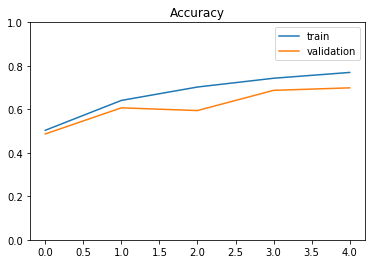

In [8]:
#==============================================
# 3-5.確認のための描画
#==============================================

import numpy as np
import matplotlib.pyplot as plt

#==================
#　精度のプロット関数
#==================
def accPlotFunc(h):
    # 0 ～ len(h.history['acc'])-1 の等差数列
    epoch = np.arange(len(h.history['acc']))
    # <class 'numpy.ndarray'>
    # 例)epoch = [0 1 2 3 4 5]
    
    # accuracy と validation accuracy の推移をプロットする
    plt.title('Accuracy')
    # y軸の範囲0.0～1.0
    plt.ylim(0.0, 1.0)
    
    #・h.historyの例:
    #  {'val_loss': [1.648613947033882, ・・・],
    #   'val_acc': [0.4728000000119209, ・・・],
    #   'loss': [1.3863265740126371, ・・・],
    #   'acc': [0.5063250005198643, ・・・]}
    
    # x軸：epoch数、y軸:h.history['acc'],凡例:train
    plt.plot(epoch, h.history['acc'], label='train')
    
    # x軸：epoch数、y軸:h.history['val_acc'],凡例:validation
    plt.plot(epoch, h.history['val_acc'], label='validation')
    
    # 凡例をグラフ上に出す
    plt.legend()
    plt.show()

#####
accPlotFunc(hist)


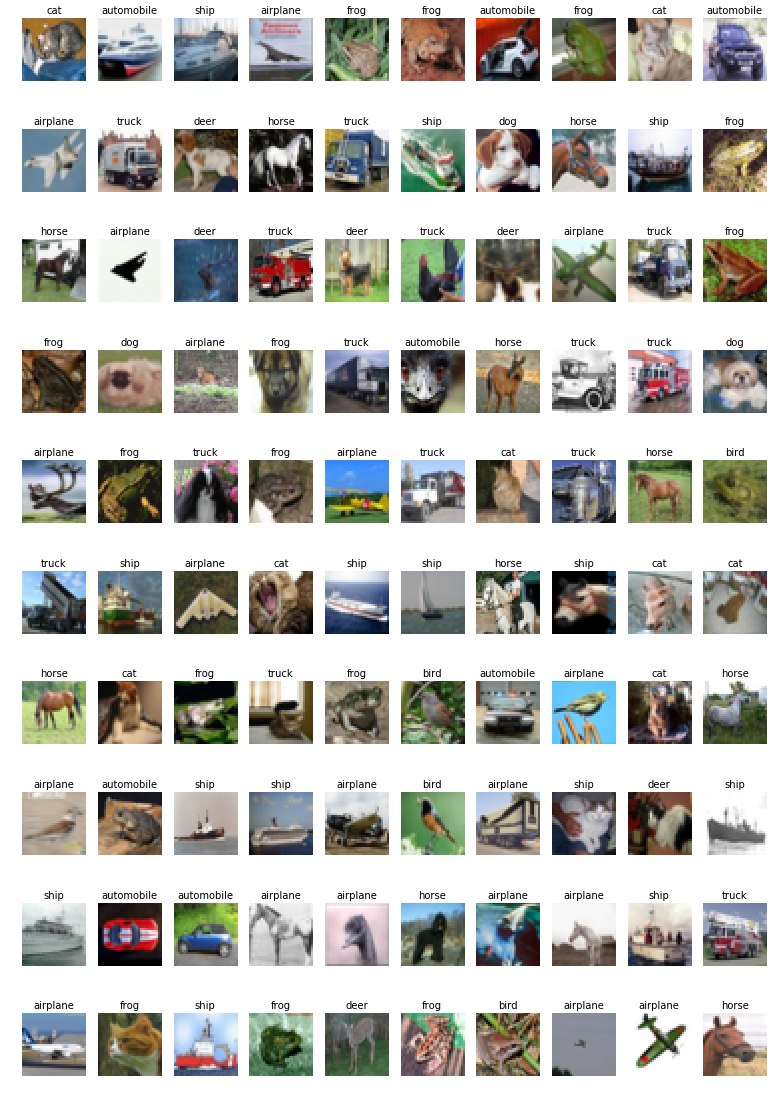

In [9]:
#==============================================
# 3-6.作ったモデルで実行
#==============================================

#==================
#　予測 + 結果の描画
#==================
def predictShow(model_input, X_test_input):
    results = model_input.predict(X_test_input)
    ##<class 'numpy.ndarray'>
    ##(10000, 10)
    ## 縦方向(↓):10000個、横方向(→)：10個
    ##例)
    ##[[9.3436189e-02 4.3639988e-03 1.2936866e-03 ... 3.6223274e-02
    ##  3.3119796e-03 3.1835388e-04]
    ## [6.4462284e-03 1.4985842e-04 2.2184736e-06 ... 2.4948406e-09
    ##  9.9338913e-01 1.2444694e-05]
    ## [5.8614958e-02 9.3148870e-04 1.7577963e-03 ... 7.5326279e-05
    ##  9.2667145e-01 1.1901227e-02]
    ## ...
    ## [1.4164560e-06 3.3334450e-06 2.0431653e-01 ... 7.9179788e-03
    ##  1.7957157e-04 2.1580227e-05]
    ## [6.8654412e-01 2.5796095e-01 3.7540432e-02 ... 1.4178273e-05
    ##  1.9961278e-04 7.5550493e-06]
    ## [8.2166589e-06 1.0961240e-06 3.4247626e-06 ... 9.8534459e-01
    ##  4.4454353e-07 2.3437798e-07]]
    
    # X_test_inputは正規化(つまり0～1)されているので、描画のために解除する。
    
    # 正規化解除
    X_test_input *= 255.0
    
    # intに変換しておく
    X_test_input = X_test_input.astype('uint8')
    
    
    pos = 1
    # w16,h24のエリアに描画する。
    plt.figure(figsize=(16,24), dpi=60)
    
    # 100個描画するループ
    for i in range(100):
      # 3次元の数値の行列を画像に変換
      img = toimage(X_test_input[i])
    
      # 値が最大の配列のindexを取得
      label = results[i].argmax()
      # 縦10×横10ファイル数を表示
      plt.subplot(10, 10, pos)
      plt.imshow(img)
      plt.axis('off')
      # ラベル文字列をタイトルとして表示
      plt.title(cifar10_labels[label])
      pos += 1        
    
    # 定性分析するため、実際に表示してみる
    # 効率よくやるには正解/不正解も出す。
    plt.show()

#####
predictShow(model, X_test)




In [0]:
# ////////////////////////////////////////////////////
# 4.Random Erasingして実施
# ////////////////////////////////////////////////////


In [0]:
#==============================================
# 4-1.★Random Erasing関数の定義★
#==============================================
def random_erasing(img, p = 0.5, s_l = 0.02, s_h = 0.4, r1 = 0.3, r2 = 1. / 0.3):
    p1 = np.random.uniform(0,1)
    if p1 < p:
        return img
    else:
        H = img.shape[0]
        W = img.shape[1]
        S = H * W
        while True:
            S_e = S * np.random.uniform(low=s_l, high=s_h)
            r_e = np.random.uniform(low=r1, high=r2)

            H_e = np.sqrt(S_e * r_e)
            W_e = np.sqrt(S_e / r_e)

            x_e = np.random.randint(0, W)
            y_e = np.random.randint(0, H)

            if x_e + W_e <= W and y_e + H_e <= H:
                img_erased = np.copy(img)
                img_erased[y_e:int(y_e + H_e + 1), x_e:int(x_e + W_e + 1), :] = np.random.uniform(0, 1)
                return img_erased


(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


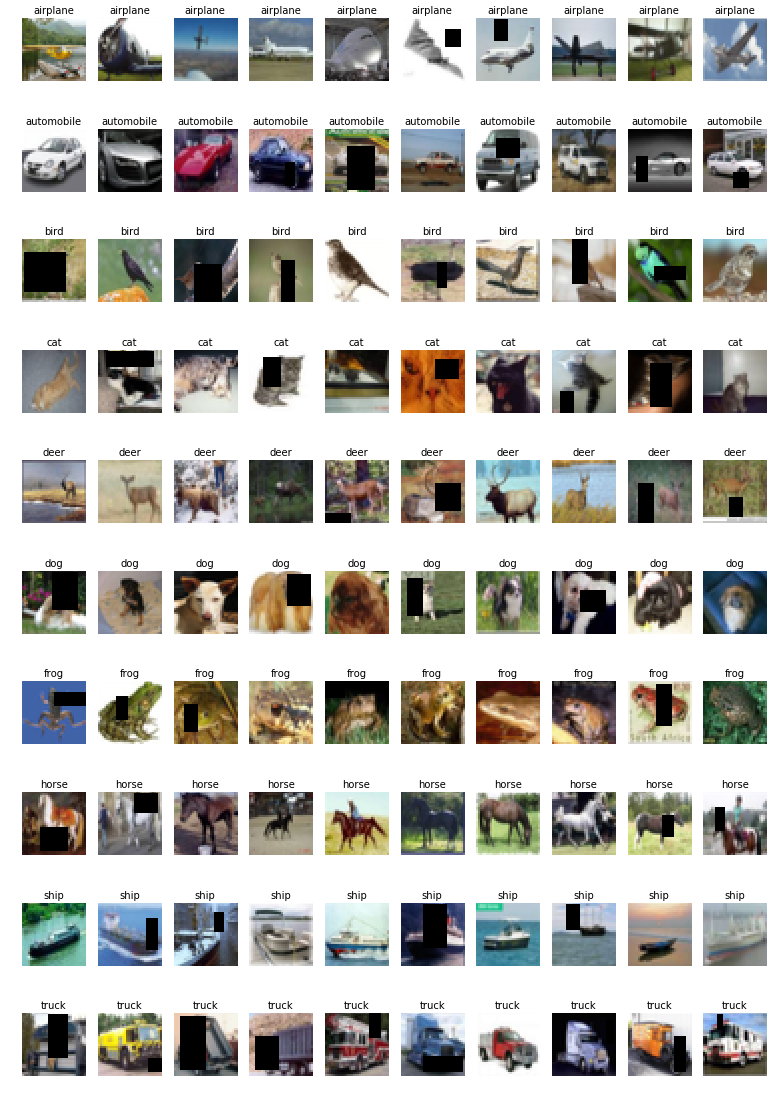

In [11]:
#==============================================
# 4-2.Random Erasingを行って事前のデータ確認
#==============================================
X_train = X_train_load.copy()
X_test = X_test_load.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


# Random Erasing関数の実行
for i in range(X_train.shape[0]):
    X_train[i] = random_erasing(X_train[i])

# 描画関数実行
classShowFunc(X_train, y_train)



In [0]:
#==============================================
# 4-3.データ変換
#==============================================

# floatに変換しておく
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 正規化
X_train /= 255.0
X_test /= 255.0


In [13]:
#==============================================
# 4-4.ResNet のモデル構築
#==============================================
model = resnet()

# optimizer として Adam を指定する。SGDでも良いがAdamのほうが収束が早い
adam = Adam()

# inputs から outputs を求める計算をするようにコンパイルする
# ここでネットワークでどのような処理を行うかが全て決定される
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# 今作ったネットワークがどんなネットワークなのか概要を表示する機能(見られるだけなので無くても良い)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 32)   4736        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 32, 32)   128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 32, 32, 32)   0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
max_poolin

In [14]:
#==============================================
# 4-5.学習
#==============================================
#####
hist = fitFunc(model, X_train, Y_train, "_randomErasing")


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 23s 573us/step - loss: 1.5091 - acc: 0.4607 - val_loss: 1.5679 - val_acc: 0.4638
Epoch 2/5
40000/40000 [==============================] - 20s 490us/step - loss: 1.1520 - acc: 0.5897 - val_loss: 1.3484 - val_acc: 0.5489
Epoch 3/5
40000/40000 [==============================] - 19s 486us/step - loss: 0.9970 - acc: 0.6493 - val_loss: 1.3173 - val_acc: 0.5476
Epoch 4/5
40000/40000 [==============================] - 19s 472us/step - loss: 0.8861 - acc: 0.6875 - val_loss: 1.2288 - val_acc: 0.5890
Epoch 5/5
40000/40000 [==============================] - 19s 466us/step - loss: 0.7971 - acc: 0.7202 - val_loss: 1.5390 - val_acc: 0.5242


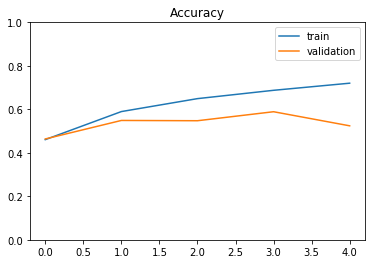

In [15]:
#==============================================
# 4-6.確認のための描画
#==============================================
#####
accPlotFunc(hist)


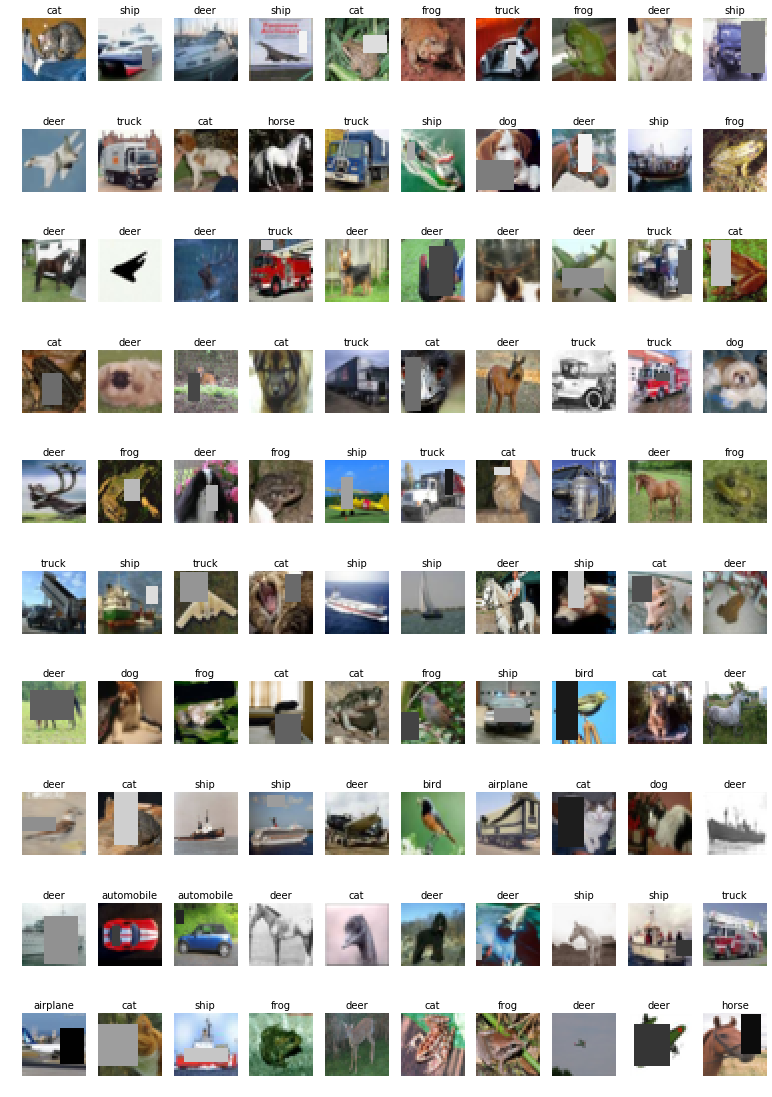

In [16]:
#==============================================
# 4-7.作ったモデルで実行
#==============================================
#####
# 学習時に行った前処理は、予測時にも当然行う。
# Random Erasing関数の実行
for i in range(X_test.shape[0]):
    X_test[i] = random_erasing(X_test[i])

predictShow(model, X_test)

